In [1]:
from __future__ import division
import os
import json
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def save_json(data, filename, _dir='afl_stats'):
    try: # make directory if it doesnt exist
        os.mkdir(_dir)
    except:
        pass
    with open(os.path.join(_dir,filename + '.json'), 'w') as fp:
        json.dump(data, fp)

In [3]:
base_dir = 'afl_stats'

In [4]:
round_dir = os.path.join(base_dir,'rounds')
match_dir = os.path.join(base_dir,'match_player_stats')
player_dir = os.path.join(base_dir,'player_summary')

In [5]:
# Make list of files with matches
rounds = []
for i in os.listdir(round_dir):
    if i[:2] == 'CD' and i[-4:] == 'json':
        rounds.append(i)

In [6]:
datadict = {}
matchdict = {}
for i in rounds:
    filepath = os.path.join(round_dir, i)
    with open(filepath, 'r') as fp:
        # Make dictionary full of data
        data = json.load(fp)
        datadict[i[:-5]] = data
        # Make dictionary of matchIds that are in each round
        matches = [item['match']['matchId'] for item in data['items']] # Get list of matchids for the round
        matchdict[i[:-5]] = matches


In [7]:
dd=datadict['CD_R200901423']

In [8]:
ddd=dd['items'][0]

In [9]:
ddd.keys()

[u'liveVideos', u'score', u'venue', u'round', u'match']

In [10]:
def process_score_dict(d):
    out = {}
    for x in ['home','away']:
        dd = d[x+'TeamScore']
        out[x+'_total_score'] = dd['matchScore']['totalScore']
        out[x+'_total_behinds'] = dd['matchScore']['behinds']
        out[x+'_total_goals'] = dd['matchScore']['goals']
        for i in dd['periodScore']:
            period_label = i['periodNumber']
            out['{}_Q{}_total_score'.format(x, period_label)] = i['score']['totalScore']
            out['{}_Q{}_behinds'.format(x, period_label)] = i['score']['behinds']
            out['{}_Q{}_goals'.format(x, period_label)] = i['score']['goals']
    try:
        out['weather_description'] = d['weather']['description']
        out['weather_temp'] = d['weather']['tempInCelsius']
        out['weather_type'] = d['weather']['weatherType']
    except:
        pass
    return out

In [11]:
#process_score_dict(ddd['score'])

In [12]:
def process_round_dict(d):
    out = {}
    out['roundAbbr'] = d['abbreviation']
    out['season'] = d['competitionId']
    out['roundId'] = d['roundId']
    out['roundNumber'] = d['roundNumber']
    out['year'] = d['year']
    out['roundName'] = d['name']
    return out

In [13]:
def process_match_dict(d):
    out = {}
    out['homeTeamId'] = d['homeTeamId']
    out['homeTeam'] = d['homeTeam']['abbr']
    out['awayTeamId'] = d['awayTeamId']
    out['awayTeam'] = d['awayTeam']['abbr']
    out['matchId'] = d['matchId']
#     out['roundId'] = d['round']
    out['datetime'] = d['utcStartTime']
    out['localtime'] = d['venueLocalStartTime']
#     out['venueId'] = d['venue']
    return out

In [14]:
def process_venue_dict(d):
    out = {}
    out['venueId'] = d['venueId']
    out['venueName'] = d['name']
    out['venueAbbr'] = d['abbreviation']
    return out

In [15]:
errorlist = []
def process_match(d):
    try:
        out={}
        out.update(process_match_dict(d['match']))
        out.update(process_round_dict(d['round']))
        out.update(process_score_dict(d['score']))
        out.update(process_venue_dict(d['venue']))
        return out
    except Exception as e:
        print d['match']['matchId']
        errorlist.append(d)
        return {}

In [16]:
matchdata = []
for k,v in iter(sorted(datadict.iteritems())) :
    for i in v['items']:
        matchdata.append(process_match(i))

CD_M20010141201
CD_M20010141207
CD_M20010141607
CD_M20020140403
CD_M20030140103
CD_M20030140306
CD_M20030141206
CD_M20030142501
CD_M20040140108
CD_M20040140208
CD_M20060141902
CD_M20070140302
CD_M20070140402
CD_M20070140908
CD_M20070141703
CD_M20070141902
CD_M20070141904
CD_M20080142101
CD_M20080142303
CD_M20090140106
CD_M20090140403
CD_M20090141003
CD_M20090141605
CD_M20100140102
CD_M20100140305
CD_M20100140503
CD_M20100140508
CD_M20100140601
CD_M20100140907
CD_M20100141103
CD_M20100141303
CD_M20100141407
CD_M20100141503
CD_M20100141506
CD_M20100141601
CD_M20100141602
CD_M20100141706
CD_M20100142106
CD_M20110140207
CD_M20110140505
CD_M20110140603
CD_M20110140806
CD_M20110140901
CD_M20110141304
CD_M20110141704
CD_M20110141906
CD_M20110142006
CD_M20110142303
CD_M20110142502
CD_M20150142303
CD_M20150142305
CD_M20150142309
CD_M20150142302
CD_M20150142304
CD_M20150142306
CD_M20150142308
CD_M20150142307
CD_M20150142301
CD_M20150142402
CD_M20150142401
CD_M20150142403
CD_M20150142404


In [17]:
mm = pd.DataFrame(matchdata)

In [18]:
mm.index = mm.matchId

In [19]:
mm.datetime = pd.to_datetime(mm.datetime) # convert to datetime

In [20]:
mm.to_pickle('matchdata.pkl')
mm.to_csv('afl_matchdata.csv')

In [21]:
matchlist = []
for k,v in iter(sorted(matchdict.iteritems())) :
    matchlist.extend(v)

In [22]:
save_json(matchlist, 'match_list')

In [23]:
test = datadict[datadict.keys()[0]]['items'][0]

In [24]:
from collections import OrderedDict

In [25]:
match_stats_dict = OrderedDict()
for i in matchlist:
    filepath = os.path.join(match_dir, i+'.json')
    try:
        with open(filepath, 'r') as fp:
            # Make dictionary full of data
            data = json.load(fp)
            match_stats_dict[i] = data
    except IOError:
        print 'Missing {}'.format(filepath)


In [26]:
team_dict = {}
def update_team_dict(team_info, team_dict=team_dict):
    if team_info['teamId'] in team_dict.keys():
        return False
    else:
        team_dict[team_info['teamId']] = team_info
        return True

In [27]:
for k,v in match_stats_dict.iteritems():
    v = v['lists']
    for i in v:
        update_team_dict(i['team'])

In [28]:
lists = match_stats_dict['CD_M20010141101']['lists']

In [29]:
from copy import deepcopy

In [30]:
def flatten_dict(d):
    out = {}
    for k,v in d.iteritems():
        if type(v)==dict:
            interim = flatten_dict(v)
            interim = {k+'_'+kk : v for kk,v in interim.iteritems()}
            out.update(interim)
        elif type(v)==list:
            interim = {k+'_'+str(i): flatten_dict(vv) for i,vv in enumerate(v)}
            out.update(interim)
                

        else:
            out[k] = v
    return out
    

In [31]:
stats_list = []
for k,v in match_stats_dict.iteritems():
    v = v['lists']
    for i in v:
        a = deepcopy(flatten_dict(i['stats']['totals']))
        a.update({u'timeOnGroundPercentage': i['stats']['timeOnGroundPercentage']})
        a.update({k:i['player'][k] for k in [u'playerId',u'surname',u'givenName']})
        a.update({k:i['team'][k] for k in [u'teamId', u'teamAbbr']})
        a.update({'matchId':k})
        stats_list.append(a)

In [32]:
import pandas as pd
from pandas import DataFrame

In [33]:
df=DataFrame(stats_list)

In [34]:
# df.to_pickle('playerMatchStats.pkl')

In [35]:
playerList = df.playerId.unique().tolist()

In [36]:
save_json(playerList,'playerId_list')

In [37]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
behinds,126876,0.427189,0.765957,0,0.0,0.0,1,11
bounces,126876,0.597851,1.268036,0,0.0,0.0,1,20
clangers,126876,1.916485,1.519406,0,1.0,2.0,3,12
clearances_centreClearances,126876,0.574459,1.039945,0,0.0,0.0,1,12
clearances_stoppageClearances,126876,1.027665,1.362996,0,0.0,1.0,2,13
clearances_totalClearances,126876,1.602123,2.000910,0,0.0,1.0,2,19
contestedMarks,126876,0.498392,0.859734,0,0.0,0.0,1,9
contestedPossessions,126876,1.381230,3.120603,0,0.0,0.0,0,29
disposalEfficiency,126876,74.659020,15.537852,0,66.7,76.2,85,100
disposals,126876,15.355741,7.131835,0,10.0,15.0,20,53


In [38]:
# Cleanup total possessions data. putting in NANs where the data is missing

In [39]:
df.totalPossessions = [np.nan if disp > 0 and pos == 0 else pos for disp, pos in zip(df.disposals, df.totalPossessions)]

In [40]:
numerical_columns = [
     u'behinds',
     u'bounces',
     u'clangers',
     u'clearances_centreClearances',
     u'clearances_stoppageClearances',
     u'clearances_totalClearances',
     u'contestedMarks',
     u'contestedPossessions',
     u'disposalEfficiency',
     u'disposals',
     u'dreamTeamPoints',
     u'freesAgainst',
     u'freesFor',
     u'goalAccuracy',
     u'goalAssists',
     u'goals',
     u'handballs',
     u'hitouts',
     u'inside50s',
     u'kicks',
     u'marks',
     u'marksInside50',
     u'onePercenters',
     u'rebound50s',
     u'tackles',
     u'timeOnGroundPercentage',
     u'totalPossessions',
     u'uncontestedPossessions']

In [41]:
# cleanup timeOnGroundPercentage to put NaNs where information is missing
df.timeOnGroundPercentage = [
    np.nan if valmax>0 and time==0 else time
    for valmax, time in zip(df[numerical_columns].T.max(), df.timeOnGroundPercentage)]

In [42]:
df.timeOnGroundPercentage.describe()

count    110585.000000
mean         81.449166
std          17.091387
min           0.000000
25%          77.000000
50%          85.000000
75%          92.000000
max         100.000000
Name: timeOnGroundPercentage, dtype: float64

In [43]:
df['round'] = df.matchId.apply(lambda x: int(x[-4:-2]))
df['year'] = df.matchId.apply(lambda x: int(x[4:8]))

In [44]:
df.to_pickle('playerMatchStats.pkl')

In [45]:
df.to_csv('afl_playerMatchStats.csv', index=False)

In [46]:
playerdata = []
for i in playerList:
    filepath = os.path.join(player_dir, i+'.json')
    with open(filepath, 'r') as fp:
        # Make dictionary full of data
        data = json.load(fp)
        data['playerId']=i
        playerdata.append(data)


In [47]:
def process_player_data(i):
    """
    Process dictionary entry for a single player
    """
    out = {}
    try:
        out['playerId'] = i['playerId']
        j = i['playerProfile']
        for k,v in j['basicStats'].iteritems():
            out[k] = v
        out['careerGamesPlayed'] = j['careerGamesPlayed']
        for k in ['surname', 'firstName', 'jumperNumber','milestones','position', 'clubAwards']:
            out[k] = j[k]
    except Exception as e:
        print 'Error with {}'.format(i['playerId'])
    return out


In [48]:
playerdf = []
for i in playerdata:
    playerdf.append(process_player_data(i))
playerdf = pd.DataFrame(playerdf)
    

Error with CD_I940033
Error with CD_I250207
Error with CD_I281151


In [49]:
playerdf.dateOfBirth = pd.to_datetime(playerdf.dateOfBirth)

In [50]:
playerdf.index = playerdf.playerId

In [51]:
playerdf['Turned18'] = [i.year+18 for i in playerdf.dateOfBirth]

In [52]:
str.isdigit('12a')

False

In [53]:
playerdf.draftYear = [int(i) if str.isdigit(str(i)) else np.nan for i in playerdf.draftYear]

/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


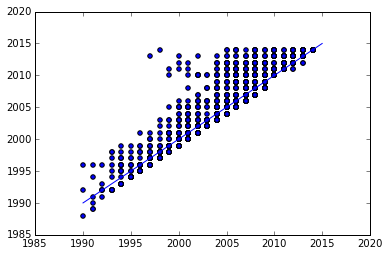

In [54]:
plt.scatter(playerdf.Turned18, playerdf.draftYear)
plt.plot([1990,2015],[1990,2015])

In [55]:
playerdf.to_pickle('player_summary.pkl')

In [56]:
playerdf.to_csv('afl_player_summary.csv', encoding='utf-8')

In [57]:
errorlist=[]
for dd in playerdata:
    try:
        print (dd['playerProfile']['surname']+', '+dd['playerProfile']['firstName']).ljust(20), str(dd['playerProfile']['careerGamesPlayed']).ljust(4), \
            str(dd['playerProfile']['basicStats']['draftYear']), dd['playerProfile']['basicStats']['debutYear'],\
            dd['playerProfile']['yearlySeasonStats'][-1]['year'], dd['playerProfile']['yearlySeasonStats'][0]['year']
    except Exception as e:
        print '### ERROR', dd['playerId'], e, '###'
        errorlist.append(dd['playerId'])

Abraham, Winston     0    None None 2001 2002
Archer, Glenn        0     None 2001 2007
Blakey, John         0    None None 2001 2002
Burton, Matthew      0    None None 2001 2003
Clayton, Shane       0     None 2001 2004
Cochrane, Stuart     0    None None 2001 2005
Colbert, Leigh       0    None None 2001 2005
Grant, Shannon       0    1994 None 2001 2008
Harris, Daniel       0    2000 None 2001 2011
Makepeace, Troy      0    1999 None 2001 2006
McCartney, Jason     0    None None 2001 2003
McKernan, Corey      0    None None 2001 2005
Motlop, Shannon      0    1998 None 2001 2006
Petrie, Drew         293  2000 2001 2001 2015
Pickett, Byron       0    1996 None 2001 2007
Rawlings, Brady      0    1998 None 2001 2011
Rocca, Saverio       0    None None 2001 2006
Simpson, Adam        0    1993 None 2001 2009
Sinclair, Jess       0    1996 None 2001 2008
Smith, Dylan         0    None None 2001 2005
Stevens, Anthony     0     None 2001 2004
Watt, Shannon        0    1997 None 2001 2009


In [58]:
errorlist

[u'CD_I940033', u'CD_I250207', u'CD_I281151']

In [59]:
df[df.playerId.isin(errorlist)][['surname','givenName','playerId']]

,surname,givenName,playerId
226,Hocking,Garry,CD_I940033
645,Hocking,Garry,CD_I940033
1041,Hocking,Garry,CD_I940033
1679,Hocking,Garry,CD_I940033
1877,Hocking,Garry,CD_I940033
2339,Hocking,Garry,CD_I940033
3043,Hocking,Garry,CD_I940033
3571,Hocking,Garry,CD_I940033
3922,Hocking,Garry,CD_I940033
4515,Hocking,Garry,CD_I940033


In [60]:
df[(df.givenName=='Will') & (df.surname=='Johnson')][['surname','givenName','playerId']]

,surname,givenName,playerId
83327,Johnson,Will,CD_I281151


In [61]:
aa=playerdata[25]['playerProfile']

In [62]:
aa.keys()

[u'bio',
 u'milestones',
 u'surname',
 u'firstName',
 u'photoUrl',
 u'aflAwards',
 u'seasonStats',
 u'yearlySeasonStats',
 u'qa',
 u'jumperNumber',
 u'careerGamesPlayed',
 u'latestPlayerRating',
 u'sponsor',
 u'clubAwards',
 u'position',
 u'careerStats',
 u'careerAverages',
 u'id',
 u'basicStats']

In [63]:
dd['surname']

KeyError: 'surname'

In [ ]:
print dd['firstName'],dd['surname'], dd['careerGamesPlayed']

In [ ]:
aa['basicStats']

In [ ]:
aa['yearlySeasonStats'][0]['year']